In [1]:
import numpy as np
import csv
import re

In [2]:
artist_id_file = open("mxm_779k_matches.txt")
msd_name_to_mxm = {} # map MSD artist name to MXM artist name
artist_name_to_tracks = {} # map MXM artist name to list of (MSD, MXM track IDs)

lines = artist_id_file.readlines()
for line in lines:
    if line[0] == '#':
        continue
    terms = re.split('<SEP>', line.rstrip())
    # we know each line is formatted as such:
    # tid|artist name|title|mxm tid|artist_name|title
    msd_name_to_mxm[terms[1]] = terms[4]
    if terms[4] in artist_name_to_tracks:
        artist_name_to_tracks[terms[4]] += (terms[0], terms[3])
    else:
        artist_name_to_tracks[terms[4]] = [(terms[0], terms[3])]
    
artist_id_file.close()

In [3]:
def construct_track_to_words(lines):
    track_to_words = {} # maps MSD track ID to np.array of word counts, indexed by all_words
    all_words = []
    for line in lines:
        if line[0] == '#':
            continue
        if line[0] == '%':
            all_words = re.split(',', line[1:].rstrip())
            continue
        content = re.split(',', line.rstrip())
        # know that lines are formatted as TID,MXMID,idx:cnt,idx:cnt,...
        word_counts = np.zeros(len(all_words))
        for term in content[2:]:
            index, count = re.split(':', term)
            index, count = int(index), int(count)
            word_counts[index-1] = count
        track_to_words[content[0]] = word_counts
    return all_words, track_to_words

In [4]:
words_dataset = open("mxm_dataset_train.txt")
lines = words_dataset.readlines()
all_words, track_to_words = construct_track_to_words(lines)
words_dataset.close()

In [5]:
words_dataset = open("mxm_dataset_test.txt")
lines = words_dataset.readlines()
output = construct_track_to_words(lines)
words_dataset.close()

In [6]:
print(len(track_to_words))
track_to_words.update(output[1])
print(len(track_to_words))

210519
237662


In [7]:
artist_name_to_word_count = {} # maps MXM artist name to np array of word count

for artist in artist_name_to_tracks:
    word_counts = np.zeros(len(all_words))
    for track_id in artist_name_to_tracks[artist]:
        track_id = track_id[0]
        if track_id in track_to_words:
            word_counts += track_to_words[track_id]
    artist_name_to_word_count[artist] = word_counts

In [8]:
artists_in_dataset = [name for name in artist_name_to_word_count if np.any(artist_name_to_word_count[name])]

In [9]:
print(len(artists_in_dataset))
print(len(artist_name_to_word_count))

9395
46469


In [10]:
filename = "artist_to_word_count.csv"
with open(filename, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile) 
        
    # writing the fields 
    csvwriter.writerow(['name'] + all_words) 
        
    # writing the data rows 
    for name in artists_in_dataset:
        csvwriter.writerow([name] + list(artist_name_to_word_count[name]))

In [12]:
# !python -m pip install lyricsgenius
from lyricsgenius import Genius
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.linalg import svds

In [13]:
token = 'M4ryjx_Lsw6ivDYBJDstefp269uJrax2fYcntlBjYDRvH70j0jNrj67xaE8q66M0'
genius = Genius(token, remove_section_headers=True, timeout=20)
genius.remove_section_headers = True

In [23]:
df = pd.read_csv('../compiled-data-filtered.csv')
artists = df['Artist']

In [25]:
artist_songs = {}
for artist in artists[:10]:
    artist_songs[artist] = genius.search_artist(artist, max_songs=5)

Searching for songs by "Cats" 1981 Original London Cast...

Changing artist name to 'Cats Original London Cast (1981)'
Done. Found 0 songs.
Searching for songs by "Weird Al" Yankovic...

Changing artist name to '“Weird Al” Yankovic'
Song 1: "Amish Paradise"
Song 2: "Word Crimes"
Song 3: "Tacky"
Song 4: "White & Nerdy"
Song 5: "The Saga Begins"

Reached user-specified song limit (5).
Done. Found 5 songs.
Searching for songs by $NOT...

Song 1: "GOSHA"
Song 2: "Moon & Stars"
Song 3: "BERETTA"
Song 4: "MEGAN"
Song 5: "Excuse Me"

Reached user-specified song limit (5).
Done. Found 5 songs.
Searching for songs by $atori Zoom...

Song 1: "BUSTER"
Song 2: "RIPSTICK"
Song 3: "LOCK OUT"
Song 4: "REVENGE"
Song 5: "Honey"

Reached user-specified song limit (5).
Done. Found 5 songs.
Searching for songs by $uicideBoy$...

Changing artist name to '$UICIDEBOY$'
Song 1: "Kill Yourself (Part III)"
Song 2: "Paris"
Song 3: "2nd Hand"
Song 4: "Antarctica"
Song 5: "I No Longer Fear the Razor Guarding My He

In [15]:
df2 = pd.read_csv('../compiled-w-songs-filtered.csv')
df2 = df2.iloc[1073:1699]
artists2 = df2[['Artist', 'Songs']]

In [17]:
artists_songs2 = dict(zip(artists2['Artist'], artists2['Songs']))
for artist in artists_songs2:
    songs = artists_songs2[artist].replace('"', "'").strip("'[]").split("', '")
    artists_songs2[artist] = songs

In [19]:
df2.tail()

,Unnamed: 0,Unnamed: 0.1,Artist,Genres,Followers,Popularity,Songs,Length
1694,4079,4079,Iriarte,['vintage tango'],256253,70,"['El Indio Enamorado', 'El Cadete', 'Mi Potra'...",10
1695,4082,4082,Irmgard Seefried,['classical soprano'],4008949,79,"['Piano Concerto No. 21 in C Major, K. 467 ""El...",10
1696,4084,4084,Iron Maiden,"['album rock', 'hard rock', 'metal', 'nwobhm',...",600585,65,"['Iron Maiden', 'Fish (feat. Raekwon & Cappado...",10
1697,4089,4089,Isaiah Rashad,"['hip hop', 'rap', 'tennessee hip hop', 'under...",844586,68,"[""Wat's Wrong (feat. Zacari & Kendrick Lamar)""...",9
1698,4090,4090,Isao Tomita,['moog'],1122563,72,"['Clair de Lune, L. 32', 'Rêverie', 'Suite ber...",10


In [18]:
song_lyrics = {}
artists2 = list(artists_songs2)

for artist in artists2:
    song_info = []
    for song in artists_songs2[artist]:
        try:
            song_info.append(genius.search_song(song, artist=artist))
        except Exception as e:
            print(song, artist, e)
    song_lyrics[artist] = song_info

Searching for "When You Leave - Breathe Carolina Remix" by Dropgun...
No results found for: 'When You Leave - Breathe Carolina Remix Dropgun'
Searching for "Happier - Breathe Carolina Remix" by Dropgun...
No results found for: 'Happier - Breathe Carolina Remix Dropgun'
Searching for "Rhythm Is A Dancer (feat. Kaleena Zanders)" by Dropgun...
Done.
Searching for "IF U" by Dropgun...
Done.
Searching for "Blackout" by Dropgun...
Specified song does not contain lyrics. Rejecting.
Searching for "Get Away (feat. Rama Duke)" by Dropgun...
No results found for: 'Get Away (feat. Rama Duke) Dropgun'
Searching for "Funny - Breathe Carolina Remix" by Dropgun...
No results found for: 'Funny - Breathe Carolina Remix Dropgun'
Searching for "All Star - Breathe Carolina Remix" by Dropgun...
No results found for: 'All Star - Breathe Carolina Remix Dropgun'
Searching for "Sellouts" by Dropgun...
No results found for: 'Sellouts Dropgun'
Searching for "Who's Laughing Now - Breathe Carolina Remix" by Dropgun

In [20]:
artist_documents = []

for artist in song_lyrics:
    all_lyrics = ""
    for song in song_lyrics[artist]:
        if song != None:
            all_lyrics += song.lyrics
    artist_documents.append(all_lyrics)

In [21]:
print(len(song_lyrics))

626


In [22]:
def build_vectorizer(max_n_terms=5000):
    """Returns a TfidfVectorizer object with certain preprocessing properties.
    
    Params: {max_n_terms: Integer,
             max_prop_docs: Float,
             min_n_docs: Integer}
    Returns: TfidfVectorizer
    """
    # YOUR CODE HERE
    return TfidfVectorizer(max_features=max_n_terms)

In [23]:
tfidf_vec = build_vectorizer()
tfidf_mat = tfidf_vec.fit_transform(artist_documents).toarray()

In [24]:
vocab = tfidf_vec.get_feature_names()
u, s, v_trans = svds(tfidf_mat, k=100)

In [25]:
print(u.shape)
print(s.shape)
print(v_trans.shape)

(626, 100)
(100,)
(100, 5000)


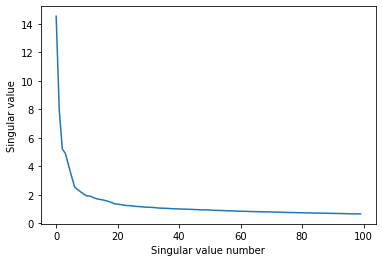

In [26]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(s[::-1])
plt.xlabel("Singular value number")
plt.ylabel("Singular value")
plt.show()

In [27]:
u, s, v_trans = svds(tfidf_mat, k=20)
v = v_trans.T

In [40]:
df3 = pd.DataFrame.from_dict(song_lyrics, orient='index')

In [37]:
df3.tail()

,0,1,2,3,4,5,6,7,8,9
Iriarte,None,None,None,None,None,None,None,None,None,None
Irmgard Seefried,None,None,None,None,None,None,None,None,None,None
Iron Maiden,"""Iron Maiden"" by Iron Maiden:\n Won't you c...","""My Very Good Favorite Songs From Recommended ...","""Songs Based On Historical Events"" by Genius L...","""My Very Good Favorite Songs From Recommended ...","""October 1990 Album Release Calendar"" by Geniu...","""Reddit AMA"" by PRhyme:\n Royce - can we ex...",None,"""My Very Good Favorite Songs From Recommended ...","""The Value of Psychotic Experience (Part 1 of ...","""What I Listened To In 2015"" by PsyQonaut:\n ..."
Isaiah Rashad,"""Best Songs of 2016 Nominations"" by Genius:\n ...","""4r da Squaw"" by Isaiah Rashad:\n Beat tigh...","""Heavenly Father"" by Isaiah Rashad:\n Yeah\...","""Free Lunch"" by Isaiah Rashad:\n Know it, s...","""Silkk da Shocka"" by Isaiah Rashad:\n Yeah,...","""Smile"" by Isaiah Rashad:\n Yeah, yeah, yea...","""My Review Of “Cilvia Demo” by Isaiah Rashad"" ...","""Stuck in the Mud"" by Isaiah Rashad:\n Part...","""Why Worry"" by Isaiah Rashad:\n Too busy li...","""Tity and Dolla"" by Isaiah Rashad:\n Yeah\n..."
Isao Tomita,None,None,None,None,None,None,None,None,None,None


In [38]:
import json
with open('artist_lyrics_1074-1699.json', 'w') as outfile:
    json.dump(artist_documents, outfile)

In [42]:
df3.to_csv('cs4300sp2021-ag2496-cc972-mb2359-jjz67-jxl8/1074-1699.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'cs4300sp2021-ag2496-cc972-mb2359-jjz67-jxl8/1074-1699.csv'